# Building an Altitude Hold Autopilot System

This notebook guides you through implementing an altitude hold autopilot system for an aircraft using the easyflight library. We'll explore how PID controllers work together to maintain a target altitude in a virtual simulation environment.

## Learning Objectives

By the end of this notebook, you should be able to:
1. Understand the components of an altitude hold autopilot system
2. Implement and tune a complete altitude hold system
3. Analyze system performance using visualization tools
4. Understand the challenges and constraints of aircraft altitude control
5. Apply the principles to other control systems (heading, speed, etc.)

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
import ipywidgets as widgets

# Import easyflight components
from easyflight.simulators import VirtualSimulator
from easyflight.aircraft import Aircraft
from easyflight.autopilot import AltitudeHold
from easyflight.controllers import PIDController
from easyflight.visualization import plot_simulation_results, plot_pid_performance, interactive_plot

# Set up plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Understanding Altitude Control in Aircraft

### The Physics of Altitude Control

Before diving into the implementation, let's understand the basics of how altitude is controlled in an aircraft:

1. **Primary Control Surface**: The elevator controls the pitch of the aircraft (nose up or down)
2. **Control Chain**:
   - Elevator position → Aircraft pitch → Vertical speed → Altitude
3. **Relationship**:
   - Pulling back on the elevator (positive) raises the nose (increases pitch)
   - Increased pitch leads to a positive vertical speed
   - Positive vertical speed leads to increasing altitude

### Altitude Hold Design Considerations

An effective altitude hold system must consider:

1. **Response Time**: How quickly the system responds to altitude deviations
2. **Stability**: Preventing oscillations or overshoots
3. **Passenger Comfort**: Limiting vertical acceleration and pitch changes
4. **Energy Efficiency**: Avoiding excessive pitch or throttle changes

## 2. Basic Altitude Hold System

Let's start by implementing a simple altitude hold system and observing its behavior:

In [ ]:
def run_altitude_hold_simulation(kp=0.01, ki=0.00, kd=0.0, 
                                 initial_altitude=5000.0, target_altitude=8000.0,
                                 simulation_time=240, dt=0.1):
    """Run a simulation of the altitude hold autopilot system."""
    # Create simulator and aircraft
    simulator = VirtualSimulator()
    aircraft = Aircraft(simulator)
    
    # Initialize aircraft state
    aircraft.reset(altitude=initial_altitude, airspeed=150.0, heading=0.0)
    
    # Create altitude hold autopilot
    altitude_hold = AltitudeHold(kp=kp, ki=ki, kd=kd)
    altitude_hold.set_target(target_altitude)
    altitude_hold.enable()
    
    # Prepare for simulation
    steps = int(simulation_time / dt)
    
    # Initialize data storage
    time_points = []
    state_history = {
        'altitude': [],
        'vertical_speed': [],
        'pitch': [],
        'pitch_rate': []
    }
    control_history = {'elevator': []}
    
    # Run simulation
    for i in range(steps):
        current_time = i * dt
        time_points.append(current_time)
        
        # Get current state
        state = aircraft.get_state()
        
        # Record state
        for key in state_history:
            state_history[key].append(state[key])
        
        # Compute control
        elevator_command = altitude_hold.compute(state)
        
        # Record control
        control_history['elevator'].append(elevator_command['elevator'])
        
        # Apply control
        aircraft.set_controls(elevator=elevator_command['elevator'])
        
        # Step simulation
        simulator.step(dt)
    
    # Create results dictionary
    results = {
        'time': time_points,
        'state': state_history,
        'control': control_history,
        'controller': altitude_hold.controller.history,
        'parameters': {
            'kp': kp,
            'ki': ki,
            'kd': kd,
            'initial_altitude': initial_altitude,
            'target_altitude': target_altitude
        }
    }
    
    return results

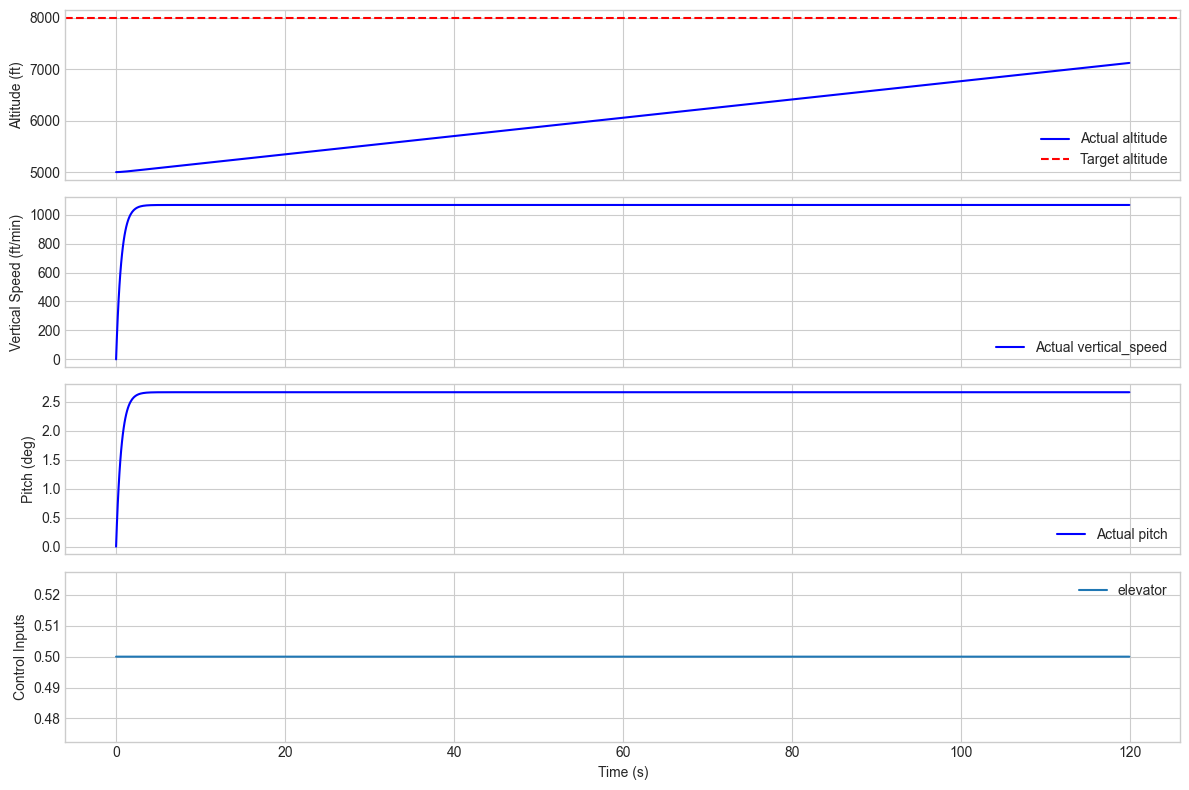

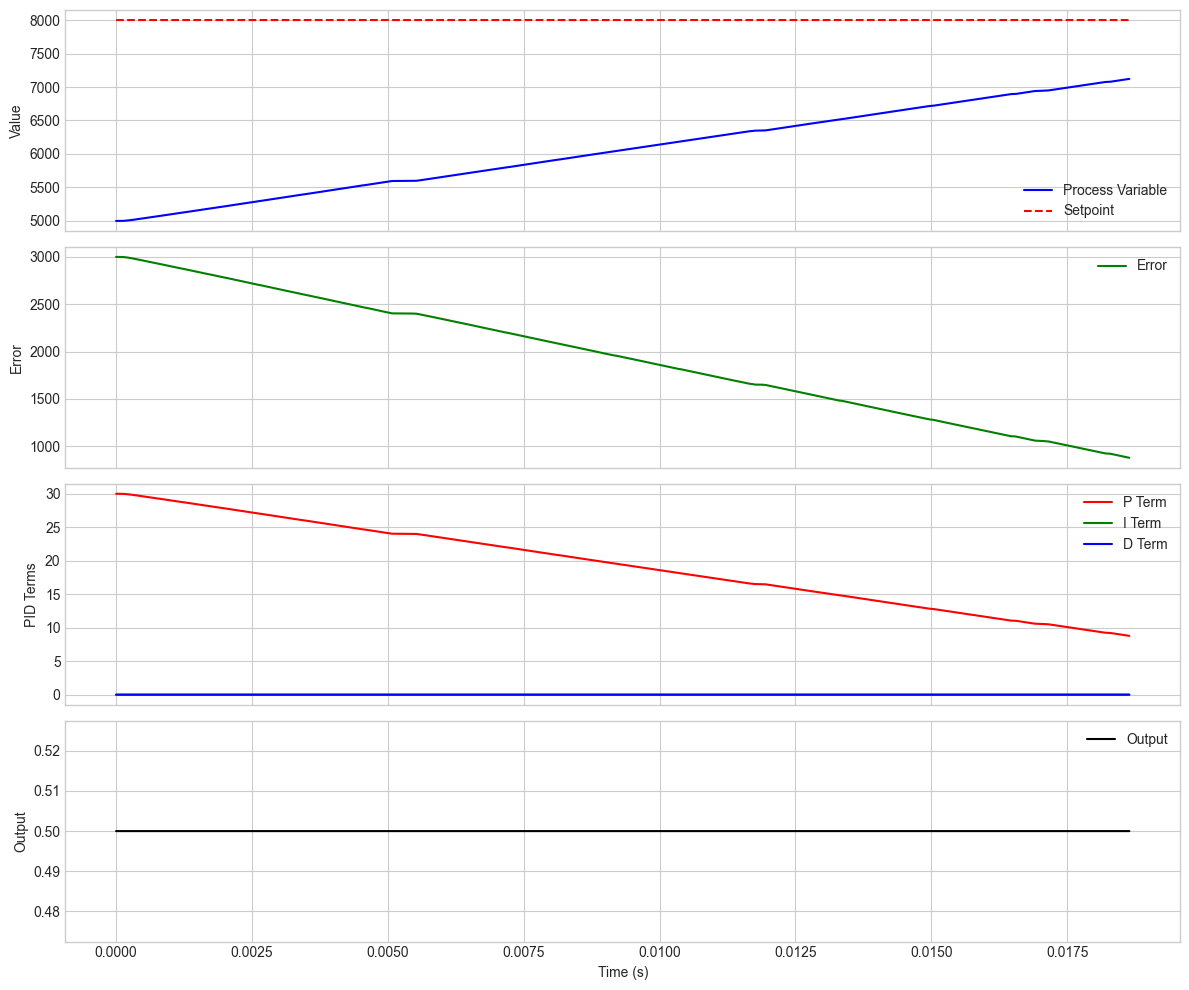

In [3]:
# Run a basic simulation
results = run_altitude_hold_simulation()

# Plot the results
fig1 = plot_simulation_results(
    results['time'],
    results['state'],
    setpoints={'altitude': results['parameters']['target_altitude']},
    control_history=results['control'],
    variables=['altitude', 'vertical_speed', 'pitch']
)

# Plot the controller performance
fig2 = plot_pid_performance(results['controller'])

### Analyzing the Results

Let's analyze what's happening in the simulation:

1. **Initial Response**: When the autopilot is engaged, it detects an altitude error (difference between current and target) and commands an elevator deflection

2. **Climb Phase**: The elevator causes the aircraft to pitch up, resulting in a positive vertical speed and increasing altitude

3. **Approaching Target**: As the aircraft approaches the target altitude, the error decreases, and the PID controller reduces the elevator command

4. **Stabilization**: Finally, the aircraft reaches and maintains the target altitude, with small corrections as needed

## 3. Tuning the Altitude Hold System

Now let's create an interactive tool to experiment with different PID parameters and observe their effects on the altitude hold performance:

In [4]:
# Create interactive widgets
kp_slider = widgets.FloatSlider(value=0.01, min=0.0, max=0.05, step=0.001, description='Kp:')
ki_slider = widgets.FloatSlider(value=0.001, min=0.0, max=0.01, step=0.0001, description='Ki:')
kd_slider = widgets.FloatSlider(value=0.05, min=0.0, max=0.2, step=0.01, description='Kd:')
initial_alt_slider = widgets.FloatSlider(value=5000.0, min=1000.0, max=10000.0, step=500.0, description='Initial Alt (ft):')
target_alt_slider = widgets.FloatSlider(value=8000.0, min=1000.0, max=15000.0, step=500.0, description='Target Alt (ft):')

# Create output widget
output = widgets.Output()

# Function to update simulation
def update_simulation(kp, ki, kd, initial_altitude, target_altitude):
    with output:
        clear_output(wait=True)
        
        # Run simulation
        results = run_altitude_hold_simulation(
            kp=kp, ki=ki, kd=kd, 
            initial_altitude=initial_altitude, 
            target_altitude=target_altitude
        )
        
        # Plot results
        fig1 = plot_simulation_results(
            results['time'],
            results['state'],
            setpoints={'altitude': results['parameters']['target_altitude']},
            control_history=results['control'],
            variables=['altitude', 'vertical_speed', 'pitch']
        )
        plt.show()
        
        fig2 = plot_pid_performance(results['controller'])
        plt.show()

# Create interactive output
interactive_output = widgets.interactive_output(
    update_simulation, 
    {
        'kp': kp_slider, 
        'ki': ki_slider, 
        'kd': kd_slider, 
        'initial_altitude': initial_alt_slider, 
        'target_altitude': target_alt_slider
    }
)

# Display widgets
display(widgets.VBox([
    widgets.HBox([kp_slider, ki_slider, kd_slider]),
    widgets.HBox([initial_alt_slider, target_alt_slider]),
    output
]))

# Initial update
update_simulation(0.01, 0.001, 0.05, 5000.0, 8000.0)

### Tuning Guidelines for Altitude Hold

As you experiment with the parameters, keep these guidelines in mind:

1. **Proportional Gain (Kp)**:
   - Increase for faster response to altitude errors
   - Too high: Causes oscillations and overshoots
   - Too low: Slow response to altitude changes
   - Typical range for altitude: 0.005 to 0.02

2. **Integral Gain (Ki)**:
   - Increase to eliminate steady-state error
   - Too high: Causes long-period oscillations
   - Too low: Persistent altitude error
   - Typical range for altitude: 0.0001 to 0.002

3. **Derivative Gain (Kd)**:
   - Increase to dampen oscillations and reduce overshoot
   - Too high: Noisy control signals, excessive damping
   - Too low: Insufficient damping, oscillations
   - Typical range for altitude: 0.02 to 0.1

## 4. Testing Altitude Hold in Different Scenarios

Now, let's test our altitude hold system in different scenarios to evaluate its robustness:

In [5]:
def run_altitude_scenario(scenario='climb', kp=0.01, ki=0.001, kd=0.05):
    """Run different altitude hold scenarios."""
    # Set up scenario parameters
    if scenario == 'climb':
        initial_altitude = 5000.0
        target_altitude = 10000.0
        simulation_time = 180
        scenario_name = "Climb (5000ft to 10000ft)"
    elif scenario == 'descent':
        initial_altitude = 10000.0
        target_altitude = 5000.0
        simulation_time = 180
        scenario_name = "Descent (10000ft to 5000ft)"
    elif scenario == 'small_correction':
        initial_altitude = 10000.0
        target_altitude = 10500.0
        simulation_time = 120
        scenario_name = "Small Correction (10000ft to 10500ft)"
    elif scenario == 'large_climb':
        initial_altitude = 5000.0
        target_altitude = 20000.0
        simulation_time = 300
        scenario_name = "Large Climb (5000ft to 20000ft)"
    else:
        initial_altitude = 5000.0
        target_altitude = 8000.0
        simulation_time = 120
        scenario_name = "Default Climb"
    
    # Run the simulation
    results = run_altitude_hold_simulation(
        kp=kp, ki=ki, kd=kd,
        initial_altitude=initial_altitude,
        target_altitude=target_altitude,
        simulation_time=simulation_time
    )
    
    # Plot the results
    fig1 = plot_simulation_results(
        results['time'],
        results['state'],
        setpoints={'altitude': target_altitude},
        control_history=results['control'],
        variables=['altitude', 'vertical_speed', 'pitch']
    )
    plt.suptitle(f"Altitude Hold: {scenario_name}", fontsize=16)
    
    # Calculate performance metrics
    altitude = np.array(results['state']['altitude'])
    time = np.array(results['time'])
    target = target_altitude
    
    # Find when we first get within 5% of target
    error_threshold = abs(target - initial_altitude) * 0.05
    mask = np.abs(altitude - target) < error_threshold
    if np.any(mask):
        rise_time = time[np.argmax(mask)]
    else:
        rise_time = np.nan
    
    # Calculate overshoot
    if initial_altitude < target_altitude:
        overshoot = max(0, np.max(altitude) - target)
        overshoot_percent = (overshoot / (target - initial_altitude)) * 100
    else:
        overshoot = max(0, target - np.min(altitude))
        overshoot_percent = (overshoot / (initial_altitude - target)) * 100
    
    # Calculate settling time (within 2% of final value)
    settle_threshold = abs(target - initial_altitude) * 0.02
    mask = np.abs(altitude - target) < settle_threshold
    if np.any(mask):
        # Find the last time we crossed the threshold
        crossings = np.where(np.diff(mask.astype(int)))[0]
        if len(crossings) > 0 and crossings[-1] < len(time) - 1:
            settling_time = time[crossings[-1] + 1]
        else:
            settling_time = time[np.argmax(mask)]
    else:
        settling_time = np.nan
    
    # Calculate steady-state error
    steady_state_error = abs(altitude[-1] - target)
    
    # Print performance metrics
    print(f"Performance Metrics for {scenario_name}:")
    print(f"Rise Time: {rise_time:.1f} seconds")
    print(f"Overshoot: {overshoot:.1f} ft ({overshoot_percent:.1f}%)")
    print(f"Settling Time: {settling_time:.1f} seconds")
    print(f"Steady-State Error: {steady_state_error:.1f} ft")
    
    return results

Performance Metrics for Climb (5000ft to 10000ft):
Rise Time: nan seconds
Overshoot: 0.0 ft (0.0%)
Settling Time: nan seconds
Steady-State Error: 1811.9 ft


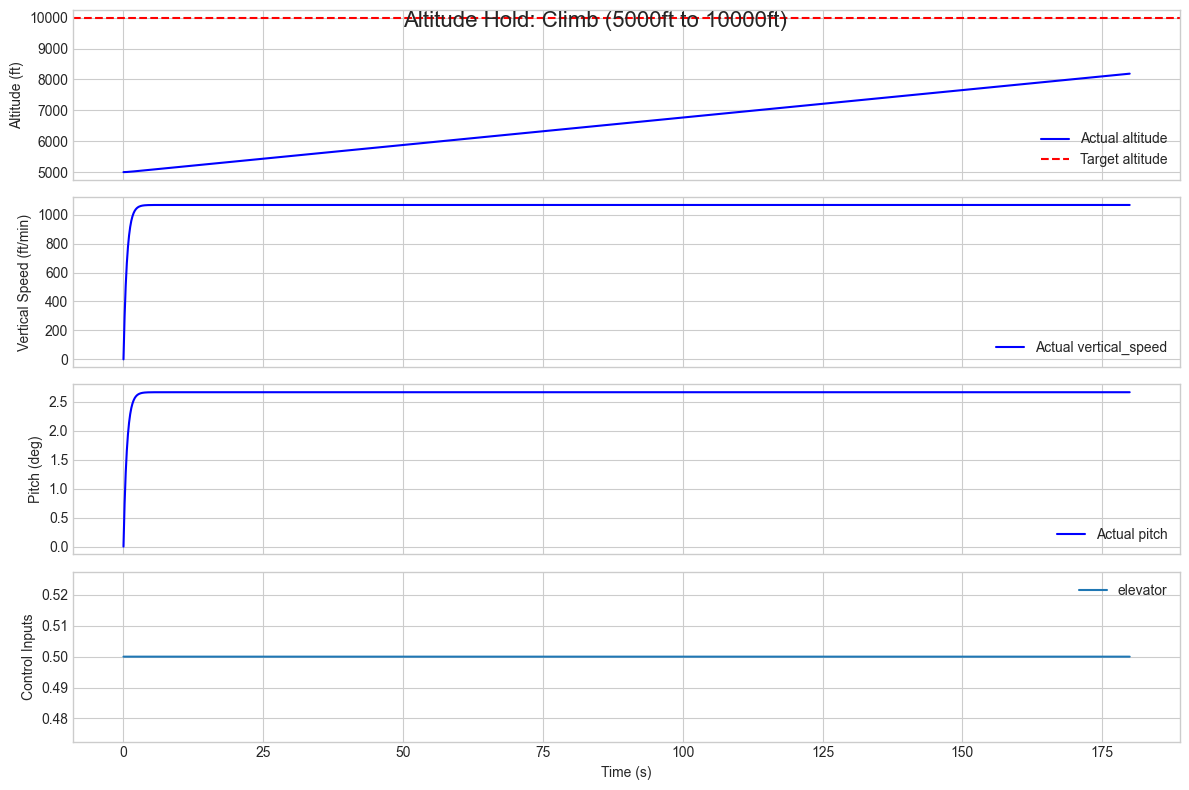

In [6]:
# Test climb scenario
climb_results = run_altitude_scenario('climb')

Performance Metrics for Descent (10000ft to 5000ft):
Rise Time: nan seconds
Overshoot: 0.0 ft (0.0%)
Settling Time: nan seconds
Steady-State Error: 1811.9 ft


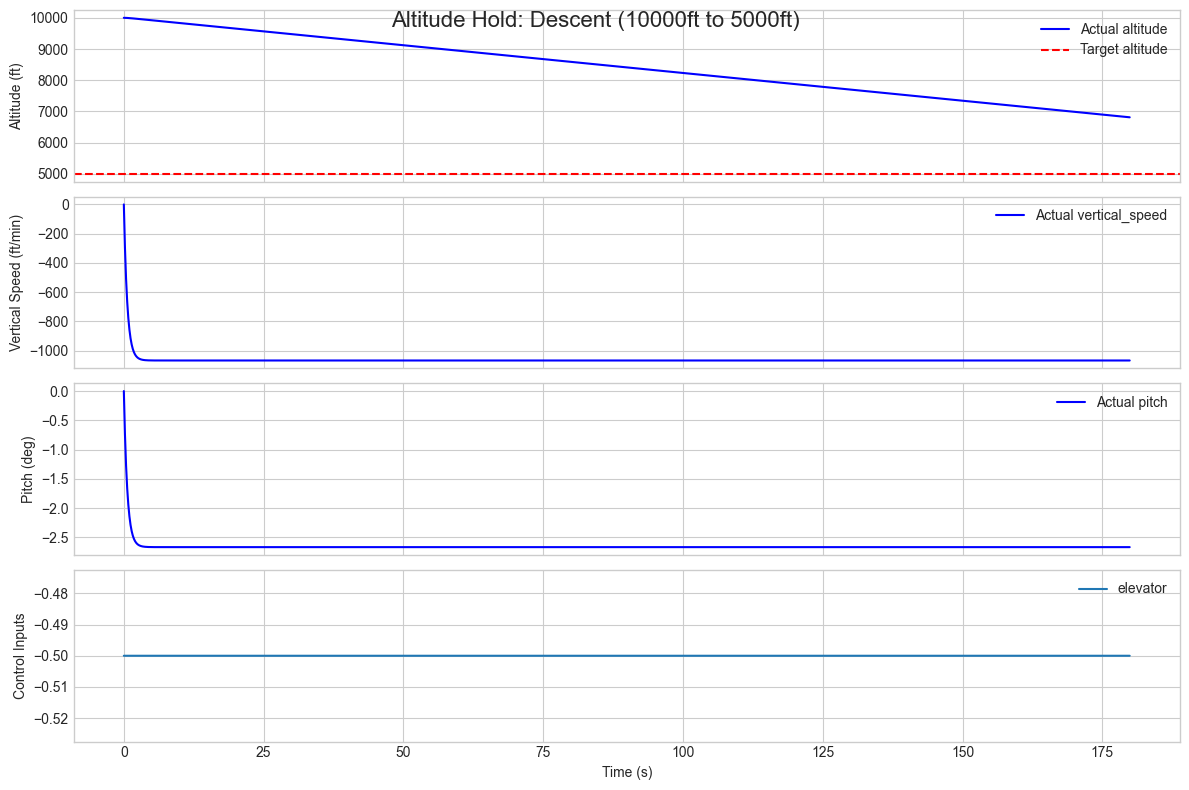

In [7]:
# Test descent scenario
descent_results = run_altitude_scenario('descent')

Performance Metrics for Small Correction (10000ft to 10500ft):
Rise Time: 34.0 seconds
Overshoot: 0.0 ft (0.0%)
Settling Time: 40.9 seconds
Steady-State Error: 0.0 ft


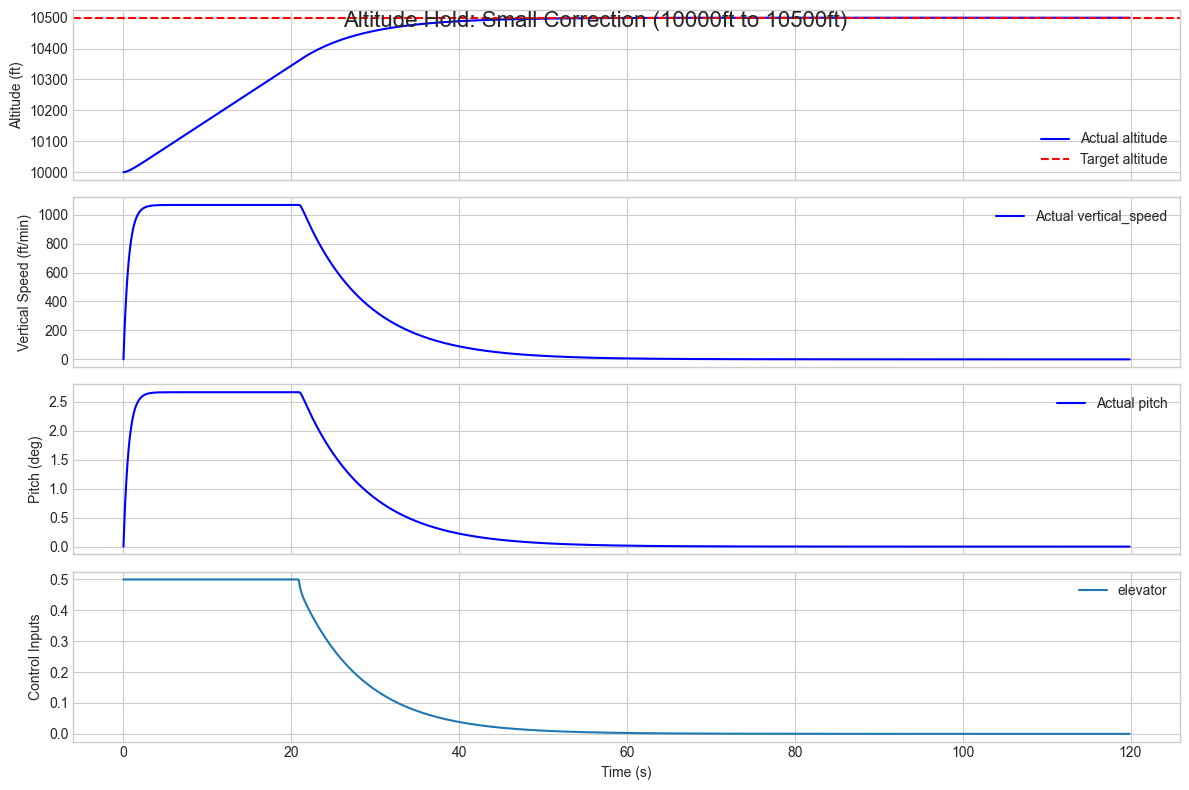

In [8]:
# Test small correction scenario
small_correction_results = run_altitude_scenario('small_correction')

## 5. Advanced Altitude Hold Features

In real aircraft autopilot systems, altitude hold often includes additional features to enhance performance and safety. Let's implement and test some of these features.

### 5.1 Vertical Speed Limiting

One important feature is vertical speed limiting, which prevents the aircraft from climbing or descending too rapidly for passenger comfort or aircraft limitations.

In [9]:
def run_with_vs_limits(vs_limit=1000.0, kp=0.01, ki=0.001, kd=0.05):
    """Run a simulation with vertical speed limiting."""
    # Create simulator and aircraft
    simulator = VirtualSimulator()
    aircraft = Aircraft(simulator)
    
    # Initialize aircraft state
    initial_altitude = 5000.0
    target_altitude = 10000.0
    aircraft.reset(altitude=initial_altitude, airspeed=150.0, heading=0.0)
    
    # Create altitude hold with VS limiting
    altitude_hold = AltitudeHold(kp=kp, ki=ki, kd=kd, vertical_speed_limit=vs_limit)
    altitude_hold.set_target(target_altitude)
    altitude_hold.enable()
    
    # Run simulation
    simulation_time = 240  # longer to accommodate slower climb
    dt = 0.1
    steps = int(simulation_time / dt)
    
    # Initialize data storage
    time_points = []
    state_history = {
        'altitude': [],
        'vertical_speed': [],
        'pitch': [],
    }
    control_history = {'elevator': []}
    
    # Run simulation
    for i in range(steps):
        current_time = i * dt
        time_points.append(current_time)
        
        # Get current state
        state = aircraft.get_state()
        
        # Record state
        for key in state_history:
            state_history[key].append(state[key])
        
        # Compute control
        elevator_command = altitude_hold.compute(state)
        
        # Record control
        control_history['elevator'].append(elevator_command['elevator'])
        
        # Apply control
        aircraft.set_controls(elevator=elevator_command['elevator'])
        
        # Step simulation
        simulator.step(dt)
    
    # Plot results
    fig1 = plot_simulation_results(
        time_points,
        state_history,
        setpoints={'altitude': target_altitude},
        control_history=control_history,
        variables=['altitude', 'vertical_speed', 'pitch']
    )
    plt.suptitle(f"Altitude Hold with {vs_limit} ft/min Vertical Speed Limit", fontsize=16)
    
    # Add horizontal lines for VS limits
    ax = plt.gcf().axes[1]
    ax.axhline(y=vs_limit, color='r', linestyle='--')
    ax.axhline(y=-vs_limit, color='r', linestyle='--')
    
    # Calculate maximum vertical speed
    max_vs = max(abs(np.array(state_history['vertical_speed'])))
    print(f"Maximum Vertical Speed: {max_vs:.1f} ft/min")
    print(f"Target VS Limit: {vs_limit:.1f} ft/min")
    
    return time_points, state_history, control_history

Maximum Vertical Speed: 1066.7 ft/min
Target VS Limit: 2000.0 ft/min


([0.0,
  0.1,
  0.2,
  0.30000000000000004,
  0.4,
  0.5,
  0.6000000000000001,
  0.7000000000000001,
  0.8,
  0.9,
  1.0,
  1.1,
  1.2000000000000002,
  1.3,
  1.4000000000000001,
  1.5,
  1.6,
  1.7000000000000002,
  1.8,
  1.9000000000000001,
  2.0,
  2.1,
  2.2,
  2.3000000000000003,
  2.4000000000000004,
  2.5,
  2.6,
  2.7,
  2.8000000000000003,
  2.9000000000000004,
  3.0,
  3.1,
  3.2,
  3.3000000000000003,
  3.4000000000000004,
  3.5,
  3.6,
  3.7,
  3.8000000000000003,
  3.9000000000000004,
  4.0,
  4.1000000000000005,
  4.2,
  4.3,
  4.4,
  4.5,
  4.6000000000000005,
  4.7,
  4.800000000000001,
  4.9,
  5.0,
  5.1000000000000005,
  5.2,
  5.300000000000001,
  5.4,
  5.5,
  5.6000000000000005,
  5.7,
  5.800000000000001,
  5.9,
  6.0,
  6.1000000000000005,
  6.2,
  6.300000000000001,
  6.4,
  6.5,
  6.6000000000000005,
  6.7,
  6.800000000000001,
  6.9,
  7.0,
  7.1000000000000005,
  7.2,
  7.300000000000001,
  7.4,
  7.5,
  7.6000000000000005,
  7.7,
  7.800000000000001,
  7

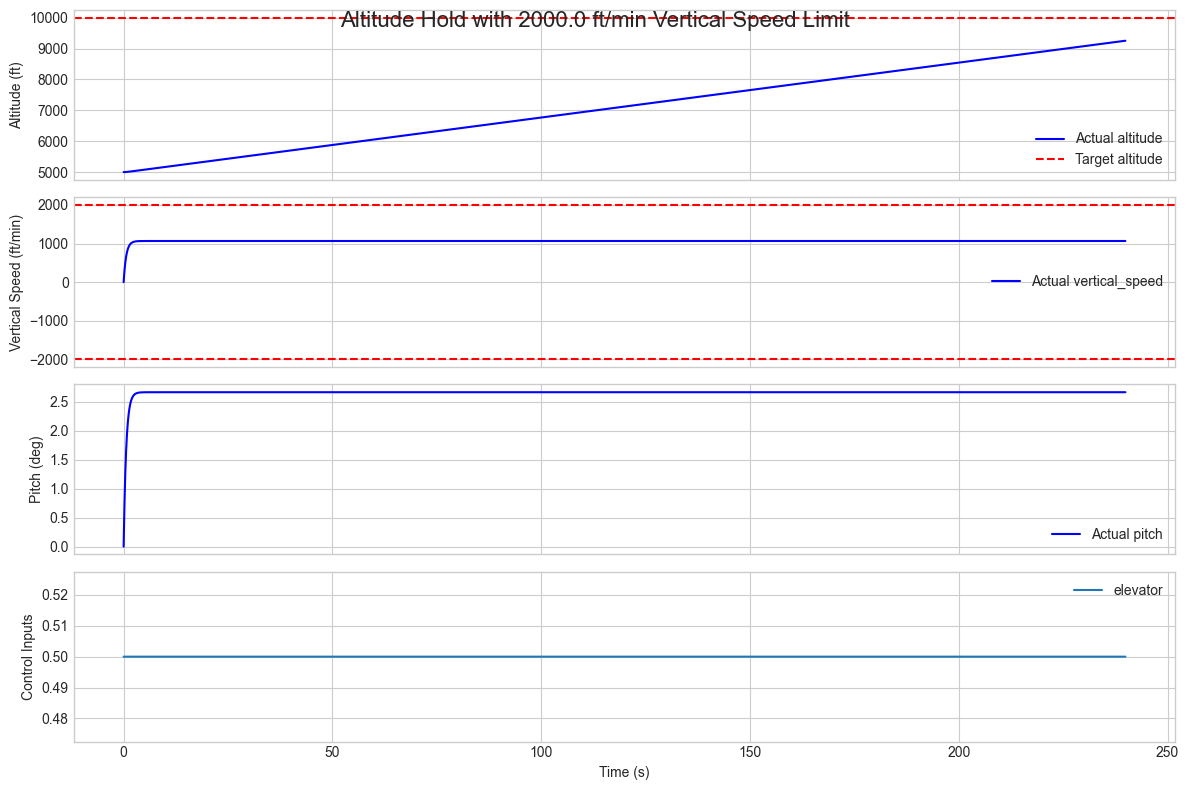

In [10]:
# Run with different vertical speed limits
run_with_vs_limits(vs_limit=2000.0)  # Standard limit

Maximum Vertical Speed: 730.3 ft/min
Target VS Limit: 500.0 ft/min


([0.0,
  0.1,
  0.2,
  0.30000000000000004,
  0.4,
  0.5,
  0.6000000000000001,
  0.7000000000000001,
  0.8,
  0.9,
  1.0,
  1.1,
  1.2000000000000002,
  1.3,
  1.4000000000000001,
  1.5,
  1.6,
  1.7000000000000002,
  1.8,
  1.9000000000000001,
  2.0,
  2.1,
  2.2,
  2.3000000000000003,
  2.4000000000000004,
  2.5,
  2.6,
  2.7,
  2.8000000000000003,
  2.9000000000000004,
  3.0,
  3.1,
  3.2,
  3.3000000000000003,
  3.4000000000000004,
  3.5,
  3.6,
  3.7,
  3.8000000000000003,
  3.9000000000000004,
  4.0,
  4.1000000000000005,
  4.2,
  4.3,
  4.4,
  4.5,
  4.6000000000000005,
  4.7,
  4.800000000000001,
  4.9,
  5.0,
  5.1000000000000005,
  5.2,
  5.300000000000001,
  5.4,
  5.5,
  5.6000000000000005,
  5.7,
  5.800000000000001,
  5.9,
  6.0,
  6.1000000000000005,
  6.2,
  6.300000000000001,
  6.4,
  6.5,
  6.6000000000000005,
  6.7,
  6.800000000000001,
  6.9,
  7.0,
  7.1000000000000005,
  7.2,
  7.300000000000001,
  7.4,
  7.5,
  7.6000000000000005,
  7.7,
  7.800000000000001,
  7

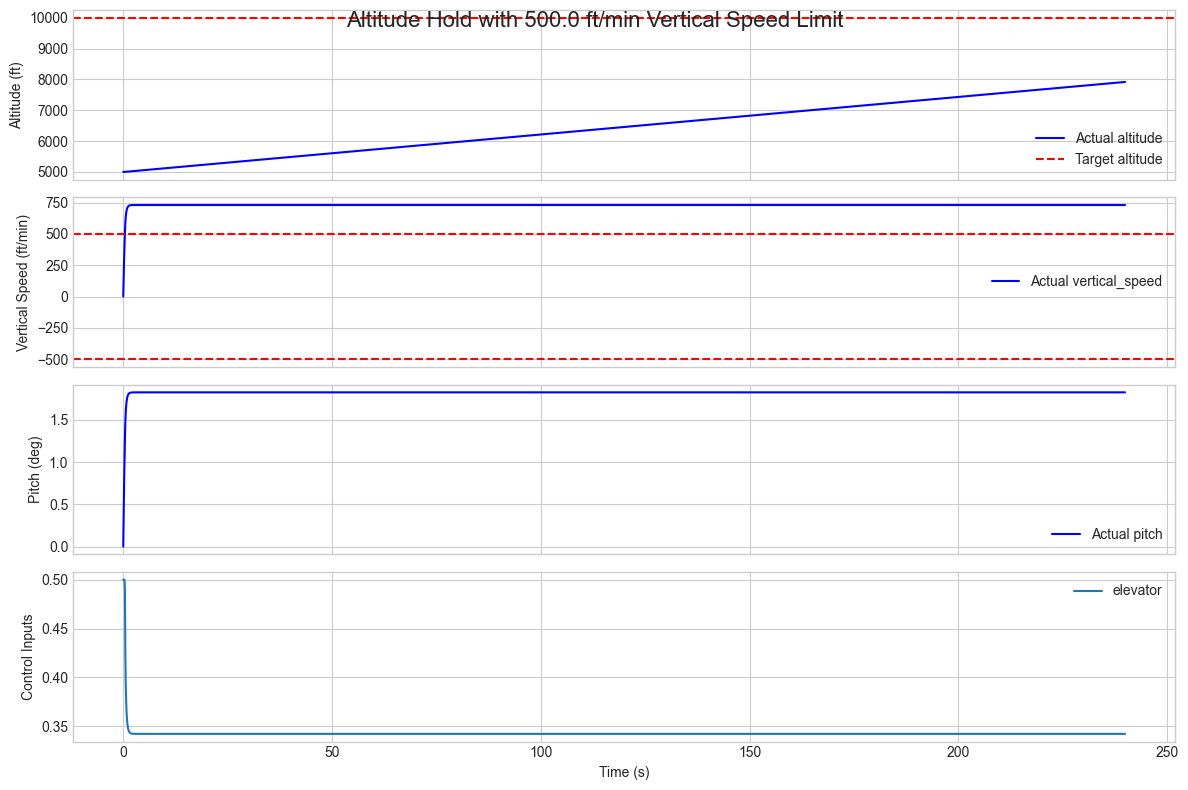

In [11]:
# Run with tighter vertical speed limits
run_with_vs_limits(vs_limit=500.0)  # More restrictive limit

### 5.2 Multi-Mode Altitude Control

Real autopilot systems often have multiple modes for altitude control, such as:
1. **Altitude Hold**: Maintains a specific altitude
2. **Vertical Speed Mode**: Climbs or descends at a specific rate
3. **Flight Level Change**: Prioritizes airspeed while changing altitude

Let's implement a simple dual-mode system that can switch between altitude hold and vertical speed modes:

In [12]:
class VerticalSpeedMode:
    """Vertical speed mode for autopilot."""
    
    def __init__(self, kp=0.01, ki=0.0, kd=0.0):
        """Initialize vertical speed mode controller."""
        self.name = "Vertical Speed Mode"
        self.controller = PIDController(
            kp=kp, ki=ki, kd=kd, 
            output_limits=(-0.5, 0.5)
        )
        self.enabled = False
        self.target_vs = 0.0
    
    def enable(self):
        """Enable vertical speed mode."""
        self.enabled = True
        self.controller.reset()
    
    def disable(self):
        """Disable vertical speed mode."""
        self.enabled = False
    
    def set_target(self, target_vs):
        """Set target vertical speed in feet per minute."""
        self.target_vs = target_vs
        self.controller.set_setpoint(target_vs)
    
    def compute(self, aircraft_state):
        """Compute elevator control to maintain target vertical speed."""
        if not self.enabled:
            return {'elevator': 0.0}
        
        # Get current vertical speed
        current_vs = aircraft_state['vertical_speed']
        
        # Compute elevator command (negative elevator = nose up)
        elevator_command = -self.controller.compute(current_vs)
        
        return {'elevator': elevator_command}


def run_multi_mode_simulation():
    """Demonstrate switching between altitude hold and vertical speed modes."""
    # Create simulator and aircraft
    simulator = VirtualSimulator()
    aircraft = Aircraft(simulator)
    
    # Initialize aircraft state
    aircraft.reset(altitude=5000.0, airspeed=150.0, heading=0.0)
    
    # Create autopilot modes
    altitude_hold = AltitudeHold(kp=0.01, ki=0.001, kd=0.05)
    vertical_speed = VerticalSpeedMode(kp=0.005, ki=0.0001, kd=0.01)
    
    # Simulation parameters
    simulation_time = 300  # seconds
    dt = 0.1  # seconds
    steps = int(simulation_time / dt)
    
    # Mode switching times and targets
    mode_schedule = [
        # (time, mode, target)
        (0, 'vs', 1000.0),      # Start climbing at 1000 ft/min
        (60, 'alt', 8000.0),    # Hold 8000 ft at t=60s
        (120, 'vs', -500.0),    # Descend at 500 ft/min at t=120s
        (180, 'alt', 5000.0),   # Hold 5000 ft at t=180s
        (240, 'vs', 1500.0),    # Climb at 1500 ft/min at t=240s
    ]
    
    # Initialize data storage
    time_points = []
    state_history = {
        'altitude': [],
        'vertical_speed': [],
        'pitch': [],
    }
    control_history = {'elevator': []}
    mode_history = []
    target_history = {'altitude': [], 'vertical_speed': []}
    
    # Initial mode
    current_mode = mode_schedule[0][1]
    if current_mode == 'vs':
        vertical_speed.set_target(mode_schedule[0][2])
        vertical_speed.enable()
        altitude_hold.disable()
        current_target_vs = mode_schedule[0][2]
        current_target_alt = None
    else:  # alt
        altitude_hold.set_target(mode_schedule[0][2])
        altitude_hold.enable()
        vertical_speed.disable()
        current_target_alt = mode_schedule[0][2]
        current_target_vs = None
    
    # Run simulation
    for i in range(steps):
        current_time = i * dt
        time_points.append(current_time)
        
        # Check for mode switch
        for switch_time, mode, target in mode_schedule:
            if abs(current_time - switch_time) < dt/2:  # Close enough to switch time
                if mode == 'vs':
                    vertical_speed.set_target(target)
                    vertical_speed.enable()
                    altitude_hold.disable()
                    current_mode = 'vs'
                    current_target_vs = target
                    current_target_alt = None
                    print(f"Switching to VS mode at t={current_time:.1f}s, Target VS: {target:.1f} ft/min")
                else:  # alt
                    altitude_hold.set_target(target)
                    altitude_hold.enable()
                    vertical_speed.disable()
                    current_mode = 'alt'
                    current_target_alt = target
                    current_target_vs = None
                    print(f"Switching to ALT mode at t={current_time:.1f}s, Target Alt: {target:.1f} ft")
        
        # Get current state
        state = aircraft.get_state()
        
        # Record state
        for key in state_history:
            state_history[key].append(state[key])
        
        # Record mode and targets
        mode_history.append(current_mode)
        target_history['altitude'].append(current_target_alt if current_target_alt is not None else state['altitude'])
        target_history['vertical_speed'].append(current_target_vs if current_target_vs is not None else 0)
        
        # Compute control based on mode
        if current_mode == 'vs':
            elevator_command = vertical_speed.compute(state)
        else:  # alt
            elevator_command = altitude_hold.compute(state)
        
        # Record control
        control_history['elevator'].append(elevator_command['elevator'])
        
        # Apply control
        aircraft.set_controls(elevator=elevator_command['elevator'])
        
        # Step simulation
        simulator.step(dt)
    
    # Plot results with mode transitions
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    
    # Plot altitude
    axes[0].plot(time_points, state_history['altitude'], 'b-', label='Altitude')
    axes[0].plot(time_points, target_history['altitude'], 'r--', label='Target Altitude')
    axes[0].set_ylabel('Altitude (ft)')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot vertical speed
    axes[1].plot(time_points, state_history['vertical_speed'], 'g-', label='Vertical Speed')
    axes[1].plot(time_points, target_history['vertical_speed'], 'r--', label='Target VS')
    axes[1].set_ylabel('Vertical Speed (ft/min)')
    axes[1].legend()
    axes[1].grid(True)
    
    # Plot elevator control
    axes[2].plot(time_points, control_history['elevator'], 'k-', label='Elevator')
    axes[2].set_ylabel('Elevator')
    axes[2].set_xlabel('Time (s)')
    axes[2].legend()
    axes[2].grid(True)
    
    # Add mode transition lines
    for ax in axes:
        for switch_time, mode, target in mode_schedule:
            ax.axvline(x=switch_time, color='gray', linestyle='--', alpha=0.5)
            if mode == 'vs':
                ax.text(switch_time+2, ax.get_ylim()[1]*0.9, f"VS: {target} ft/min", fontsize=8)
            else:
                ax.text(switch_time+2, ax.get_ylim()[1]*0.9, f"ALT: {target} ft", fontsize=8)
    
    plt.suptitle("Multi-Mode Altitude Control", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    
    return time_points, state_history, control_history, mode_history, target_history

Switching to VS mode at t=0.0s, Target VS: 1000.0 ft/min
Switching to ALT mode at t=60.0s, Target Alt: 8000.0 ft
Switching to VS mode at t=120.0s, Target VS: -500.0 ft/min
Switching to ALT mode at t=180.0s, Target Alt: 5000.0 ft
Switching to VS mode at t=240.0s, Target VS: 1500.0 ft/min


([0.0,
  0.1,
  0.2,
  0.30000000000000004,
  0.4,
  0.5,
  0.6000000000000001,
  0.7000000000000001,
  0.8,
  0.9,
  1.0,
  1.1,
  1.2000000000000002,
  1.3,
  1.4000000000000001,
  1.5,
  1.6,
  1.7000000000000002,
  1.8,
  1.9000000000000001,
  2.0,
  2.1,
  2.2,
  2.3000000000000003,
  2.4000000000000004,
  2.5,
  2.6,
  2.7,
  2.8000000000000003,
  2.9000000000000004,
  3.0,
  3.1,
  3.2,
  3.3000000000000003,
  3.4000000000000004,
  3.5,
  3.6,
  3.7,
  3.8000000000000003,
  3.9000000000000004,
  4.0,
  4.1000000000000005,
  4.2,
  4.3,
  4.4,
  4.5,
  4.6000000000000005,
  4.7,
  4.800000000000001,
  4.9,
  5.0,
  5.1000000000000005,
  5.2,
  5.300000000000001,
  5.4,
  5.5,
  5.6000000000000005,
  5.7,
  5.800000000000001,
  5.9,
  6.0,
  6.1000000000000005,
  6.2,
  6.300000000000001,
  6.4,
  6.5,
  6.6000000000000005,
  6.7,
  6.800000000000001,
  6.9,
  7.0,
  7.1000000000000005,
  7.2,
  7.300000000000001,
  7.4,
  7.5,
  7.6000000000000005,
  7.7,
  7.800000000000001,
  7

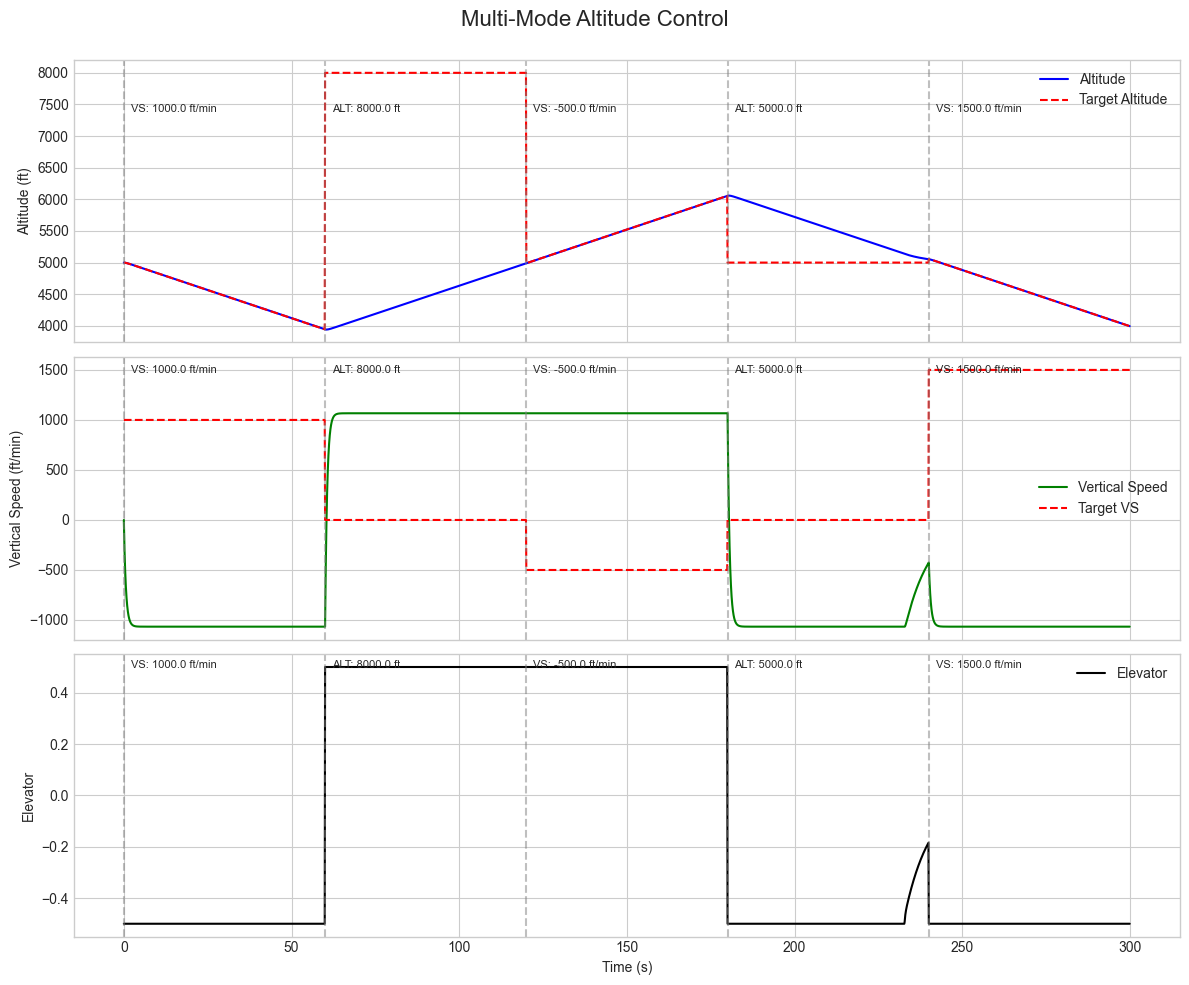

In [13]:
# Run multi-mode simulation
run_multi_mode_simulation()

## 6. Performance Analysis and Optimization

Now let's analyze the performance of our altitude hold system and optimize it for different criteria such as response time, comfort, and stability.

In [14]:
def evaluate_pid_parameters(kp_range, ki_range, kd_range, scenario='climb'):
    """Evaluate performance across a range of PID parameters."""
    # Define scenario parameters
    if scenario == 'climb':
        initial_altitude = 5000.0
        target_altitude = 10000.0
        simulation_time = 180
    elif scenario == 'descent':
        initial_altitude = 10000.0
        target_altitude = 5000.0
        simulation_time = 180
    else:
        initial_altitude = 5000.0
        target_altitude = 8000.0
        simulation_time = 120
    
    # Create results storage
    results = []
    
    # Loop through parameters
    for kp in kp_range:
        for ki in ki_range:
            for kd in kd_range:
                # Run simulation
                sim_results = run_altitude_hold_simulation(
                    kp=kp, ki=ki, kd=kd,
                    initial_altitude=initial_altitude,
                    target_altitude=target_altitude,
                    simulation_time=simulation_time
                )
                
                # Calculate metrics
                altitude = np.array(sim_results['state']['altitude'])
                time = np.array(sim_results['time'])
                target = target_altitude
                
                # Rise time (time to reach 95% of target)
                error_threshold = abs(target - initial_altitude) * 0.05
                mask = np.abs(altitude - target) < error_threshold
                if np.any(mask):
                    rise_time = time[np.argmax(mask)]
                else:
                    rise_time = np.nan
                
                # Overshoot
                if initial_altitude < target_altitude:
                    overshoot = max(0, np.max(altitude) - target)
                    overshoot_percent = (overshoot / (target - initial_altitude)) * 100
                else:
                    overshoot = max(0, target - np.min(altitude))
                    overshoot_percent = (overshoot / (initial_altitude - target)) * 100
                
                # Settling time (within 2% of final value)
                settle_threshold = abs(target - initial_altitude) * 0.02
                mask = np.abs(altitude - target) < settle_threshold
                if np.any(mask):
                    # Find the last time we crossed the threshold
                    crossings = np.where(np.diff(mask.astype(int)))[0]
                    if len(crossings) > 0 and crossings[-1] < len(time) - 1:
                        settling_time = time[crossings[-1] + 1]
                    else:
                        settling_time = time[np.argmax(mask)]
                else:
                    settling_time = np.nan
                
                # Steady-state error
                steady_state_error = abs(altitude[-1] - target)
                
                # Maximum vertical acceleration (comfort metric)
                vertical_speed = np.array(sim_results['state']['vertical_speed'])
                vertical_accel = np.diff(vertical_speed) / 0.1  # ft/min/s
                max_vs_accel = np.max(np.abs(vertical_accel))
                
                # Control effort (smoothness metric)
                elevator = np.array(sim_results['control']['elevator'])
                control_variance = np.var(elevator)
                
                # Store results
                results.append({
                    'kp': kp,
                    'ki': ki,
                    'kd': kd,
                    'rise_time': rise_time,
                    'overshoot_percent': overshoot_percent,
                    'settling_time': settling_time,
                    'steady_state_error': steady_state_error,
                    'max_vs_accel': max_vs_accel,
                    'control_variance': control_variance
                })
                
                print(f"Evaluated Kp={kp}, Ki={ki}, Kd={kd}")
    
    return results

In [15]:
# Define parameter ranges to test
kp_range = [0.005, 0.01, 0.02]
ki_range = [0.0005, 0.001, 0.002]
kd_range = [0.02, 0.05, 0.1]

# Evaluate parameters (this will take some time)
evaluation_results = evaluate_pid_parameters(kp_range, ki_range, kd_range, scenario='climb')

Evaluated Kp=0.005, Ki=0.0005, Kd=0.02
Evaluated Kp=0.005, Ki=0.0005, Kd=0.05
Evaluated Kp=0.005, Ki=0.0005, Kd=0.1
Evaluated Kp=0.005, Ki=0.001, Kd=0.02
Evaluated Kp=0.005, Ki=0.001, Kd=0.05
Evaluated Kp=0.005, Ki=0.001, Kd=0.1
Evaluated Kp=0.005, Ki=0.002, Kd=0.02
Evaluated Kp=0.005, Ki=0.002, Kd=0.05
Evaluated Kp=0.005, Ki=0.002, Kd=0.1
Evaluated Kp=0.01, Ki=0.0005, Kd=0.02
Evaluated Kp=0.01, Ki=0.0005, Kd=0.05
Evaluated Kp=0.01, Ki=0.0005, Kd=0.1
Evaluated Kp=0.01, Ki=0.001, Kd=0.02
Evaluated Kp=0.01, Ki=0.001, Kd=0.05
Evaluated Kp=0.01, Ki=0.001, Kd=0.1
Evaluated Kp=0.01, Ki=0.002, Kd=0.02
Evaluated Kp=0.01, Ki=0.002, Kd=0.05
Evaluated Kp=0.01, Ki=0.002, Kd=0.1
Evaluated Kp=0.02, Ki=0.0005, Kd=0.02
Evaluated Kp=0.02, Ki=0.0005, Kd=0.05
Evaluated Kp=0.02, Ki=0.0005, Kd=0.1
Evaluated Kp=0.02, Ki=0.001, Kd=0.02
Evaluated Kp=0.02, Ki=0.001, Kd=0.05
Evaluated Kp=0.02, Ki=0.001, Kd=0.1
Evaluated Kp=0.02, Ki=0.002, Kd=0.02
Evaluated Kp=0.02, Ki=0.002, Kd=0.05
Evaluated Kp=0.02, Ki=0.002,

In [16]:
# Display results in a table
import pandas as pd

# Convert to DataFrame
results_df = pd.DataFrame(evaluation_results)

# Sort by different criteria
print("\nOptimized for Fast Response (Minimum Rise Time):")
display(results_df.sort_values('rise_time').head(3))

print("\nOptimized for Stability (Minimum Overshoot):")
display(results_df.sort_values('overshoot_percent').head(3))

print("\nOptimized for Comfort (Minimum Vertical Acceleration):")
display(results_df.sort_values('max_vs_accel').head(3))

print("\nOptimized for Accuracy (Minimum Steady-State Error):")
display(results_df.sort_values('steady_state_error').head(3))

ModuleNotFoundError: No module named 'pandas'

## 7. Conclusions and Further Study

In this notebook, we've implemented and analyzed an altitude hold autopilot system for aircraft. Here's a summary of what we've learned:

1. **PID Control for Altitude Hold**:
   - Proportional term provides immediate response to altitude errors
   - Integral term eliminates steady-state errors
   - Derivative term improves stability and reduces oscillations

2. **Performance Tradeoffs**:
   - Fast response vs. stability
   - Accuracy vs. comfort
   - Simple control vs. robust performance

3. **Advanced Features**:
   - Vertical speed limiting for passenger comfort
   - Multi-mode operation for different flight phases
   - Performance analysis and optimization

### Further Study

To continue your exploration of aircraft autopilot systems, consider these topics:

1. **Complete Autopilot Integration**:
   - Combine altitude, heading, and speed control
   - Implement mode logic and transitions
   - Add safety protections and envelope limitations

2. **Advanced Control Techniques**:
   - Gain scheduling based on flight conditions
   - Model Predictive Control (MPC)
   - Adaptive control for changing aircraft parameters

3. **Real-World Testing**:
   - Connect to X-Plane for higher-fidelity simulation
   - Test with different aircraft types
   - Evaluate performance in turbulence and wind conditions

4. **User Interface Development**:
   - Create a cockpit-like interface for controlling the autopilot
   - Implement proper mode annunciation and warnings
   - Add flight director guidance visualization